In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.datasets import load_iris
data = load_iris()
data.keys()
df = pd.DataFrame(data = data['data'],columns = data['feature_names'])
X = np.array(df)
y = np.array(data['target'])
from sklearn.utils import shuffle
X, y = shuffle(X, y)
print(X.shape)
print(y.shape)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

(150, 4)
(150,)


In [3]:
len(np.where((y == 0) | (y == 1))[0])

100

In [4]:
#reduce to a 2 class problem
X = X[np.where((y == 0) | (y == 1))[0]]
y = y[np.where((y == 0) | (y == 1))[0]]

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
clf = RandomForestClassifier()
clf.fit(X,y)
print(cross_val_score(clf, X, y)) 

#Perfect separation!

[ 1.  1.  1.]


In [6]:
#use PCA to visualize:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_plot = pca.fit_transform(X)
X_plot.shape

(100, 2)

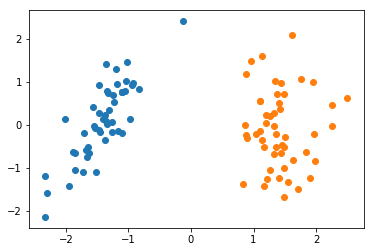

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X_plot[np.where(y==0)].T[0],X_plot[np.where(y==0)].T[1])
ax.scatter(X_plot[np.where(y==1)].T[0],X_plot[np.where(y==1)].T[1]);
#We can see the the classes are perfectly separated when projected into 2 dimentions

In [8]:
#Now on to the Neural Network:

#Helper Functions
def sigmoid(x):
    return 1/(1+np.exp(-x))

def d_sigmoid(x):
    return sigmoid(x)*(1-sigmoid(x))

def tanh(x):
    return np.tanh(x)

def d_tanh(x):
    return 1-np.tanh(x)**2


def MSE(y_output,y_actual):
    n = len(y_actual)
    return np.sum((y_output.T-y_actual)**2)/n


def d_MSE(y_output,y_actual):
    n = len(y_actual)
    return (2/n)*np.sum(y_output-y_actual)

def cross_entropy(a, y):
    n = len(y)
    y = y.reshape(n,1)
    C = -(1/n)*np.sum(y*np.log(a)+(1-y)*np.log(1-a))
    return C

def d_cross_entropy(a, y):
    n = len(y)
    #y = y.reshape(n,1)
    d_C = -(1/n)*np.sum((a-y)/((a-1)*a))
    return  d_C



#The goal is to set it up so that we can use BATCH, Mini-Batch, or SGD(batch size 1), depending on the input size. 

In [9]:
# y_output = np.array([.01,.9,.99,.01])
# y_actual = np.array([1,0,0,1])

#y_output = np.array([.9,0.1,0.1,.9])
#y_actual = np.array([1,0,0,1])

#y_output = np.array([.1,0.9,0.1,.9])
#y_actual = np.array([1,0,0,1])

y_output = np.array([.000009,.00001])
y_actual = np.array([1,0])

cross_entropy(y_output,y_actual)

11.565615222844391

In [10]:
d_tanh(y_actual)

array([ 0.41997434,  1.        ])

In [11]:
'''
--Network Architecture--

           IN(X)          FC1           A1           OUT           A2             SCORE
SGD:      (1x4)          (1x10)       (1x10)        (1x1)         (1x1)           (1) 
BATCH:   (100x4)        (100x10)     (100x10)      (100x1)       (100x1)          (1)

                  X*w0    >>  sig(fc1)  >>   a1*w1    >>  sig(out)  >>  mse(a2) >>
                   (4x10)                      (10x1)
Going to forego biases for now. Because the data is linearly seperable with lines through the origin,
I think that this should work fine for this particular problem.  
'''
def forward(x,y_actual,w0,w1,b0,b1):
    fc1 = x.dot(w0)+b0
    #print('fc1: ',fc1.shape)
    
    a1 = sigmoid(fc1)
    #print('a1: ',a1.shape)
    
    out = a1.dot(w1)+b1
    #print('out: ',out.shape)
    
    a2 = sigmoid(out)
    #print('a2: ',a2.shape)
    
    score = cross_entropy(a2, y_actual)
    print('score: ',score)
    
    return x,y_actual,w0,w1,b0,b1,fc1,a1,out,a2,score

def backward(x,y_actual,w0,w1,b0,b1,fc1,a1,out,a2,score,learning_rate):
    print('d_cross_entropy',d_cross_entropy(a2,y_actual).shape)
    print((a2-y_actual).shape)
    
    d_score_d_w1 = a1.T.dot(d_cross_entropy(a2,y_actual)*d_sigmoid(out))
    #print(d_score_d_w1)
    
    d_score_d_b1 = d_cross_entropy(a2,y_actual)*d_sigmoid(out)
    #print(d_score_d_w1)
    
    
    
    d_score_d_w0 = X.T.dot((d_cross_entropy(a2,y_actual)*d_sigmoid(out)).dot(w1.T)*d_sigmoid(fc1))
    #print(d_score_d_w0)
    
    d_score_d_b0 = (d_cross_entropy(a2,y_actual)*d_sigmoid(out)).dot(w1.T)*d_sigmoid(fc1)
    #print(d_score_d_w0)
    
    w1 = w1 - learning_rate * d_score_d_w1
    b1 = b1 - learning_rate * d_score_d_b1
    w0 = w0 - learning_rate * d_score_d_w0
    b0 = b0 - learning_rate * d_score_d_b0
    
    return x,y_actual,w0,w1,b0,b1,fc1,a1,out,a2,score

In [20]:
#Hyperparameters
learning_rate = 0.01
epochs = 4
#batch_size = 100
x = X
y_actual = y#.reshape(100,1)
#x = X[:5]
#y_actual = y[:5]
#x = X[3]
w0 = (np.random.randn(4,2)-1)*.01
b0 = (np.random.randn(len(x),2)-1)*.01
w1 = (np.random.randn(2,1)-1)*.01
b1 = (np.random.randn(len(x),1)-1)*.01

In [21]:
#batches = x   #Set batches to each individual x. (SGD)
batches = [x] #Set batch to all of x.

for epoch in range(epochs):
    print('-----------Epoch ,',epoch)
    for i,batch in enumerate(batches):
        x,y_actual,w0,w1,b0,b1,fc1,a1,out,a2,score = forward(x,y_actual,w0,w1,b0,b1) 
        #print(np.hstack((a2,y_actual.reshape(100,1)))[10:20])
        print(w0[0][0],w1[0][0])
        x,y_actual,w0,w1,b0,b1,fc1,a1,out,a2,score = backward(x,y_actual,w0,w1,b0,b1,fc1,a1,out,a2,score,learning_rate)
        print(w0[0][0],w1[0][0])

-----------Epoch , 0
score:  0.693328451792
-0.0163166764285 -0.00282373180554
d_cross_entropy ()
(100, 100)
-0.0162541904626 0.0947594304675
-----------Epoch , 1
score:  0.694362110794
-0.0162541904626 0.0947594304675
d_cross_entropy ()
(100, 100)
0.00819442178896 -1.04309376825
-----------Epoch , 2
score:  0.840844429645
0.00819442178896 -1.04309376825
d_cross_entropy ()
(100, 100)
2.88323052909 10.6271640159
-----------Epoch , 3
score:  0.41728399936
2.88323052909 10.6271640159
d_cross_entropy ()
(100, 100)
48690124.6095 -5261855.40103


In [22]:
print(w0)

[[ 48690124.60946519  49917356.3427834 ]
 [ 93127825.54759592  95163065.36613226]
 [ 12553344.64016698  12968545.53337999]
 [ 12327625.78808711  12611096.60811755]]


In [23]:
print(np.hstack((out,a2,y_actual.reshape(100,1))))

[[  0.20657726   0.55146144   0.        ]
 [  0.20086575   0.55004828   0.        ]
 [  0.72520775   0.67375277   1.        ]
 [  0.24032316   0.55979329   0.        ]
 [  0.20733301   0.55164837   0.        ]
 [  0.21544666   0.55365429   0.        ]
 [ 11.08775825   0.9999847    1.        ]
 [  0.21635999   0.55387998   0.        ]
 [ 21.2898205    1.           1.        ]
 [ 14.02675227   0.99999919   1.        ]
 [ 12.22164556   0.99999508   1.        ]
 [ 21.36504214   1.           1.        ]
 [  0.20845299   0.55192536   0.        ]
 [  0.55080054   0.6343213    1.        ]
 [  0.21604101   0.55380116   0.        ]
 [ 21.40331961   1.           1.        ]
 [  0.21535547   0.55363175   0.        ]
 [ 15.41322189   0.9999998    1.        ]
 [ 13.81378916   0.999999     1.        ]
 [ 21.31272476   1.           1.        ]
 [  0.21991988   0.55475945   0.        ]
 [ 20.62321043   1.           1.        ]
 [  0.2052683    0.55113764   0.        ]
 [  0.22212522   0.5553041    0.  

In [19]:
#for reference, a more thourough step by step way of back-propogating the gradients
def backward_old(x,y_actual,w0,w1,fc1,a1,out,a2,score, learning_rate):
    d_score_d_a2 = d_MSE(a2,y_actual)
    #print('d_score_d_a2: ',d_score_d_a2.shape)
    
    d_a2_d_out = d_sigmoid(out)
    #print('d_a2_d_out: ',d_a2_d_out.shape)
    
    d_out_d_a1 = w1
    #print('d_out_d_a1: ',d_out_d_a1.shape)
    
    d_a1_d_fc1 = d_sigmoid(fc1)
    #print('d_a1_d_fc1: ',d_a1_d_fc1.shape)

    #Chains
    d_score_d_out = d_score_d_a2 * d_a2_d_out
    #  (5x1)           (1)            (5x1)
    #print('d_score_d_out: ',d_score_d_out.shape)
    
    d_score_d_a1 = d_score_d_out.dot(d_out_d_a1.T)
    #  (5x10)          (5x1)            (1x10)
    #print('d_score_d_a1: ',d_score_d_a1.shape)
    
    d_score_d_fc1 = d_score_d_a1 * d_a1_d_fc1
    #  (5x10)         (5x10)         (5x10)   
    #print('d_score_d_fc1: ',d_score_d_fc1.shape)
    
    
    #Weights
    d_score_d_w1 = a1.T.dot(d_score_d_out)
    #   (10x1)       (10x5)     (5x1)    
    #print('d_score_d_w1: ',d_score_d_w1.shape)
    print(d_score_d_w1)
    
    d_score_d_w0 = x.T.dot(d_score_d_fc1)
    #   (4x10)    (4x5)      (5x10)
    #print('d_score_d_w0: ',d_score_d_w0.shape)
    print(d_score_d_w0)
    
    #Update Weights: Gradient Descent Step
    
    w1 += -learning_rate * d_score_d_w1
    w0 += -learning_rate * d_score_d_w0
    #print('Update:')
    #print(-learning_rate * d_score_d_w1)
    
    #return x,y_actual,w0,w1,fc1,a1,out,a2,score